In [876]:
# @title Библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from tqdm import tqdm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind_from_stats

In [882]:
# @title Upload
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'kfc-kiosk-3' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

# Running this code will display the query used to generate your previous job
# Сделать возможность выгружать из гитхаба
job = client.get_job('bquxjob_38170b1c_18c8ecb9ae0') # Job ID inserted based on the query results selected to explore
print(job.query)

job = client.get_job('bquxjob_38170b1c_18c8ecb9ae0') # Job ID inserted based on the query results selected to explore

test_kiosk_data = job.to_dataframe()
cc_data = pd.read_excel('/content/cc.xlsx')
kassa_data = pd.read_excel('/content/kassa.xlsx')

SELECT 
event_date,
restraunt_id, 
app_version,
device_version,
auth_check,
countif(event_name = 'action_order_start') as order_start_count,
countif(event_name = 'action_order_success') as order_success_count,
sum(order_value) as revenue,
avg(product_count) as avg_products
FROM `kfc-kiosk-3.analytics_342207469.only_auth_kiosk_data` 
Where status = 'online_checks'
group by event_date, restraunt_id, app_version, device_version, auth_check
Order by event_date, restraunt_id, app_version, device_version, auth_check



In [ ]:
# @title Predprocess
def test_excel_table_prepare(excel_data):
  excel_data = excel_data.drop(['Franchisee Name', 'City', 'Name', 'Facility',
                 'AGC (Net)', 'Rating', 'Dish Quantity', 'Period',
                 'DoW', 'RestPick', 'Rest excl'], axis=1)
  excel_data = excel_data.rename(columns={'Code': 'restraunt_id',
                                          'Date': 'event_date', 'Net Sales':'revenue',
                                          'Checs Qnt': 'order_success_count'})
  excel_data = excel_data[excel_data['restraunt_id'].isin(GetRestraunts())]
  excel_data['event_date'] =  pd.to_datetime(excel_data['event_date']).dt.strftime('%Y-%m-%d')
  excel_data.insert(1, 'day_of_week', pd.to_datetime(excel_data['event_date']).dt.day_name())
  return excel_data

def control_excel_table_prepare(excel_data):
  excel_data = excel_data.drop(['Franchisee Name', 'City', 'Name', 'Facility',
                 'AGC (Net)', 'Rating', 'Dish Quantity', 'Period',
                 'DoW', 'RestPick', 'Rest excl'], axis=1)
  excel_data = excel_data.rename(columns={'Code': 'restraunt_id',
                                          'Date': 'event_date', 'Net Sales':'revenue',
                                          'Checs Qnt': 'order_success_count'})
  excel_data = excel_data[~excel_data['restraunt_id'].isin(GetRestraunts())]
  excel_data['event_date'] =  pd.to_datetime(excel_data['event_date']).dt.strftime('%Y-%m-%d')
  excel_data.insert(1, 'day_of_week', pd.to_datetime(excel_data['event_date']).dt.day_name())
  return excel_data

def bigquery_table_predproccess(data):
  data['event_date'] =  pd.to_datetime(data['event_date']).dt.strftime('%Y-%m-%d')
  data.insert(1, 'day_of_week', pd.to_datetime(data['event_date']).dt.day_name())
  data = data[test_kiosk_data['event_date'] > '2023-12-01']
  return data

test_kiosk_data = bigquery_table_predproccess(test_kiosk_data)
test_kiosk_data['channel'] = 'kiosk'

test_cc_data = test_excel_table_prepare(cc_data)
control_cc_data = control_excel_table_prepare(cc_data)
test_cc_data['channel'] = 'cc'
control_cc_data['channel'] = 'cc'

test_kassa_data = test_excel_table_prepare(kassa_data)
control_kassa_data = control_excel_table_prepare(kassa_data)
test_kassa_data['channel'] = 'kassa'
control_kassa_data['channel'] = 'kassa'

In [884]:
# @title Функции
def GetRestraunts():
  return [74020587, 74013270, 74020449, 74021433, 74021788, 74020871, 74020660, 74021978, 74020896,
           74012184, 74020851, 74020828, 74021003, 74021914, 74021880, 74021975, 74321670, 74321666,
           74215106, 74021329, 74021678, 74021302, 74021639]

def ChooseSlice(data, slice_type, aggregator, aggregation_type):
    return round(data.groupby(slice_type.split(', '), as_index = False) \
          .aggregate({aggregator: aggregation_type}), 2)

def SlicesList(data):
  slice_count = 5
  return data.columns.to_list()[:slice_count]

def AggregationList(data):
  slice_count = 5
  return data.columns.to_list()[slice_count:]

def DateCheck(data):
  return data.event_date.min(), data.event_date.max()

def hist_check(aggregated_data, x_axis, y_axis):
    plt.figure(figsize=(10, 6))  # Задаем размер графика
    sns.barplot(x=aggregated_data.index, y=aggregated_data[y_axis])
    plt.title('Гистограмма на основе агрегированных данных')  # Заголовок графика
    plt.xlabel(x_axis)  # Название оси x
    plt.ylabel(y_axis)  # Название оси y
    plt.show()

def qq_plot_from_choose_slice(aggregated_data, slice_type, aggregator, aggregation_type):

    # Создание Q-Q графика
    fig, ax = plt.subplots(figsize=(10, 6))
    sm.qqplot(aggregated_data[aggregator], line ='45', ax=ax)

    # Формируем случайные данные с нормальным распределением для сравнения
    np.random.seed(0)
    sorted_data = np.sort(aggregated_data[aggregator])
    normal_data = np.random.normal(np.mean(sorted_data), np.std(sorted_data), len(sorted_data))
    sorted_normal_data = np.sort(normal_data
)
    # Добавляем данные нормального распределения на график
    ax.scatter(sorted_normal_data, sorted_data, color='b', s=10, label='Данные')
    ax.plot([np.min(sorted_normal_data), np.max(sorted_normal_data)], [np.min(sorted_normal_data), np.max(sorted_normal_data)], color='r', label='Идеальное нормальное распределение')

    # Настройка графика
    plt.title('Q-Q график')
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Упорядоченные наблюдения')
    plt.legend()
    plt.show()

def shapiro_test(aggregated_data):
    stat, p_value = stats.shapiro(aggregated_data[aggregator])

    # Выводим результат теста
    print("Статистика теста:", stat)
    print("p-значение:", p_value)

    # Проверяем уровень значимости
    alpha = 0.05
    if p_value > alpha:
        return "Распределение похоже на нормальное (не отвергаем H0)"
    else:
        return "Распределение отличается от нормального (отвергаем H0)"

def ks_test(data):
    # Генерируем выборку из стандартного нормального распределения той же длины, что и входные данные
    normal_sample = np.random.normal(0, 1, len(data))

    # Выполняем тест Колмогорова-Смирнова
    stat, p_value = stats.kstest(data, normal_sample)

    # Отображаем результаты теста
    print("Статистика теста:", stat)
    print("p-значение:", p_value)

    # Проверяем уровень значимости
    alpha = 0.05
    if p_value > alpha:
        print("Распределение похоже на нормальное (не отвергаем H0)")
    else:
        print("Распределение отличается от нормального (отвергаем H0)")

def ConcatMineAndMarketingData(aggregated_kiosk_data, kassa_data, cc_data, slice_type, aggregator):
    slice_cols = slice_type.split(', ')
    a = pd.concat([aggregated_kiosk_data, kassa_data[slice_cols + [aggregator]]])
    b = pd.concat([a, cc_data[slice_cols + [aggregator]]])
    return b

def VarCheck(var1, var2):
  return var1.var(), var2.var()

# @title Проверка на нормальность
def NormCheck(data):
  confidence_interval(data)
  hist_check(data, slice_type, aggregator)
  qq_plot_from_choose_slice(data, slice_type, aggregator, aggregation_type)
  return print(shapiro_test(data), '\n', confidence_interval(data))

def confidence_interval(aggregated_data):
  mean = aggregated_data[aggregator].mean()
  std_dev = aggregated_data[aggregator].std()
  n = len(aggregated_data[aggregator])
  z = 1.96  # Для 95% доверительного интервала (для других уровней доверия используй другое значение)
  margin_of_error = z * (std_dev / np.sqrt(n))
  confidence_interval = (round(mean - margin_of_error,-4), round(mean + margin_of_error,-4))
  return "Доверительный интервал для среднего значения:", confidence_interval

def t_yiulch_test(aggregated_data):
  stats.ttest_ind(aggregated_data[aggregated_data.ab_test == 'Control'], \
                  aggregated_data[aggregated_data.ab_test == 'Test'], equal_var = False )

def mannwhitneyu_test(aggregated_data):
  stats.mannwhitneyu(aggregated_data[aggregated_data.ab_test == 'Control'], \
                      aggregated_data[aggregated_data.ab_test == 'Test'], alternative='two-sided')

-

In [886]:
print(DateCheck(control_cc_data)) # Интервал выгрузки
print(SlicesList(control_cc_data)) # Список возможных срезов
print(AggregationList(control_cc_data)) # Список возможных аггрегаторов

('2023-12-02', '2023-12-21')
['restraunt_id', 'day_of_week', 'event_date', 'revenue', 'order_success_count']
['channel']


Сравнение количества заказов и выручки до и после обновления авторизации.
Насколько упала конверсия по киоскам.

In [887]:
# @title Функции
def SplitGroups(data, ab_test_start_date, flag):
  if flag == 'date':
    data['ab_test'] = 'no_test'
    for i in range(int(data.event_date.count())):
      if (data.event_date[i] > ab_test_start_date):
        data['ab_test'][i] = 'Test'
      if (data.event_date[i] < ab_test_start_date):
        data['ab_test'][i] = 'Control'
      if (data.event_date[i] == ab_test_start_date):
        data['ab_test'][i] = '---Start'
    return data[data.ab_test == 'Control'], \
           data[data.ab_test == 'Test']

def ChannelAggregation(kiosk_data, kassa_data, cc_data):
  aggregated_kiosk_data = ChooseSlice(kiosk_data, slice_type, aggregator, aggregation_type)
  aggregated_kassa_data = ChooseSlice(kassa_data, slice_type, aggregator, aggregation_type)
  aggregated_cc_data = ChooseSlice(cc_data, slice_type, aggregator, aggregation_type)

  channel_aggregation = ChooseSlice(ConcatMineAndMarketingData(aggregated_kiosk_data, \
                                 aggregated_kassa_data, aggregated_cc_data, slice_type, aggregator) \
                                 .sort_values(slice_type.split(', ')).reset_index().drop('index', axis=1), \
                                 slice_type, aggregator, aggregation_type)
  return channel_aggregation

def GetSplit(aggregation, parameter):
  after , before = SplitGroups(aggregation, ab_test_start_date, 'date')
  if len(parameter) == 0:
    return after, before
  else:
    return after.query(parameter), before.query(parameter)

def GetStats(data):
  return data[aggregator].mean(), \
         data[aggregator].var(ddof=1), \
         data[aggregator].count()

In [ ]:
ab_test_start_date = '2023-12-15' ## ввести дату старта аб теста
slice_type = 'event_date, restraunt_id, ' # по каким полям аггрегируем
aggregator = 'revenue'
aggregation_type = 'mean'
parameter = '' # restraunt_id == 74020587

# тестовая группа
test_channel_aggregation = ChannelAggregation(test_kiosk_data, test_kassa_data, test_cc_data)
test_channel_aggregation
# контрольная группа
control_channel_aggregation = ChannelAggregation(test_kiosk_data, control_kassa_data, control_cc_data)
test_before, test_after = GetSplit(test_channel_aggregation, parameter)
control_before, control_after = GetSplit(control_channel_aggregation, parameter)
control = control_after
test = test_after
abar, avar, na = GetStats(test)
bbar, bvar, nb = GetStats(control)

# 2 Sample T-Test
t2, p2 = ttest_ind_from_stats(abar, np.sqrt(avar), na,
                              bbar, np.sqrt(bvar), nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

In [907]:
GetStats(control)

(44187.01833333333, 246015146.52429667, 6)

In [908]:
GetStats(test)

(56083.189999999995, 79444891.22299995, 6)

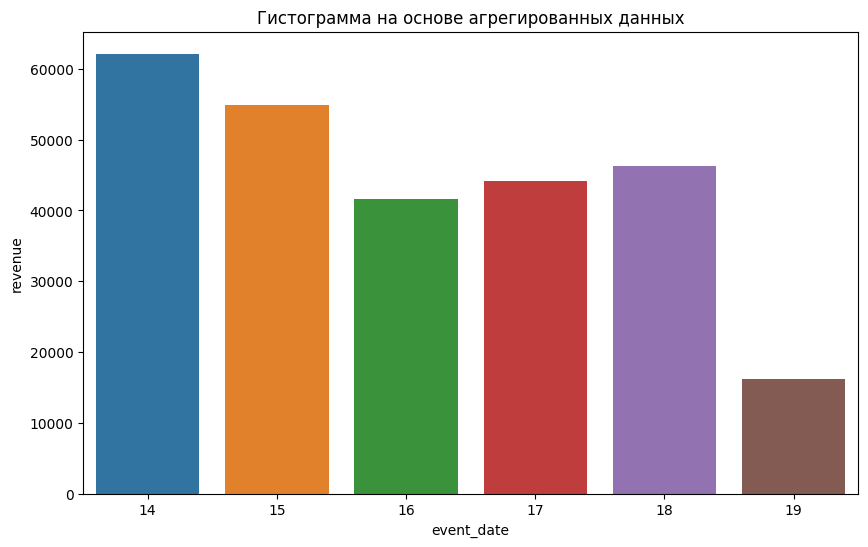

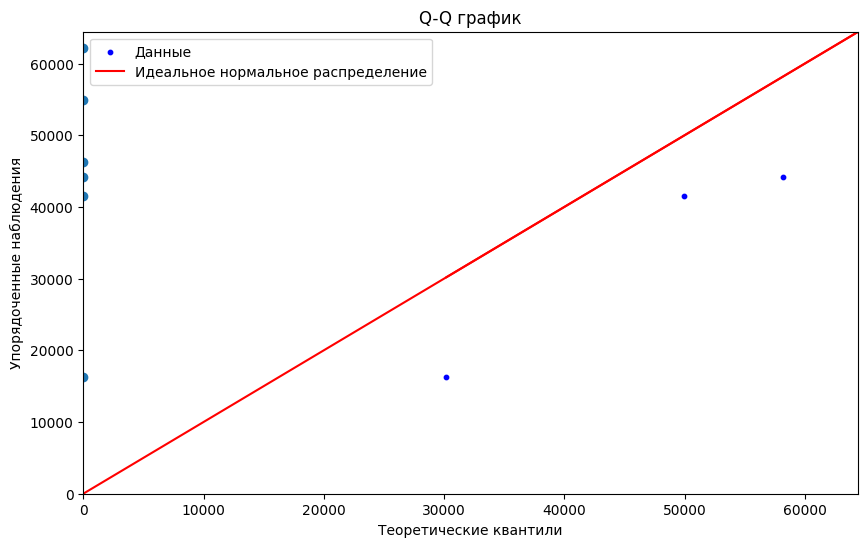

Статистика теста: 0.9100567698478699
p-значение: 0.43677017092704773
Распределение похоже на нормальное (не отвергаем H0) 
 ('Доверительный интервал для среднего значения:', (30000.0, 60000.0))


In [903]:
NormCheck(control)

In [ ]:
welch_t, welch_p = stats.ttest_ind(control[aggregator].astype(float), \
                                   test[aggregator].astype(float), equal_var=False)
print("Welch T-test:")
print("T-statistic: ", welch_t)
print("p-value: ", welch_p, '\n')

student_t, student_p = stats.ttest_ind(control[aggregator].astype(float), \
                                   test[aggregator].astype(float), equal_var=True)
print("Student T-test:")
print("T-statistic: ", welch_t)
print("p-value: ", welch_p, '\n')

u, p = stats.mannwhitneyu(control[aggregator].astype(float), \
                                   test[aggregator].astype(float), alternative='two-sided')

print("Mann-Whitney U-test:")
print("U-statistic: ", u)
print("p-value: ", p, '\n')
